# Framing the Problem

***Do left-wing states recieve more positive sentiment ads related to 'vaccines' on Facebook comapred to right-wing states during 2020-2021?***

Using Facebook's Ads Library API our goal was to analyze political ads containing specific keyword **vaccine during the durations of 2020-21** to discern something about misinformation (our overarching topic). With this goal in mind, our project is centered around primarily EDA of this data. Over our analysis, the data science techniques used for our EDA include usage of pretrained models to obtain sentiment, visual development, and permutation testing.

# Data Cleaning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
# Largest Context:
sns.set_context("paper")
import re
import numpy as np

In [2]:
df = pd.read_csv('data/vaccine_sentiment.csv')

In [3]:
df.head()

,ad_creation_time,ad_creative_bodies,ad_creative_link_titles,ad_delivery_start_time,ad_delivery_stop_time,delivery_by_region,demographic_distribution,estimated_audience_size,impressions,spend,id,sentiment
0,2021-04-16,when it comes to medical decisions it should b...,['Wisconsin DHS pauses Johnson & Johnson COVID...,2021-04-16,2021-04-18,"[{'percentage': '0.201422', 'region': 'Minneso...","[{'percentage': '0.001183', 'age': '65+', 'gen...","{'lower_bound': '100001', 'upper_bound': '5000...","{'lower_bound': '1000', 'upper_bound': '1999'}","{'lower_bound': '0', 'upper_bound': '99'}",242120184266932,Negative
1,2021-12-03,its all about issues we should be paying more ...,"['Altruisa', ' ', ' ', ' ', ' ', ' ', ' ', ' ']",2021-12-04,2021-12-08,"[{'percentage': '0.45181', 'region': 'Californ...","[{'percentage': '0.003579', 'age': '25-34', 'g...",{'lower_bound': '1000001'},"{'lower_bound': '2000', 'upper_bound': '2999'}","{'lower_bound': '0', 'upper_bound': '99'}",611908426810835,Neutral
2,2021-06-11,i will let you decide for yourself but take a ...,['UW Health - Vaccine PSA'],2021-06-11,2021-06-16,"[{'percentage': '1', 'region': 'Wisconsin'}]","[{'percentage': '0.000145', 'age': '18-24', 'g...",{'lower_bound': '1000001'},"{'lower_bound': '10000', 'upper_bound': '14999'}","{'lower_bound': '0', 'upper_bound': '99'}",899414300908039,Neutral
3,2021-09-30,small businesses are the lifeblood of the comm...,['VOTE to support small business in La Mesa'],2021-10-01,2021-10-05,"[{'percentage': '1', 'region': 'California'}]","[{'percentage': '0.004132', 'age': '35-44', 'g...","{'lower_bound': '10001', 'upper_bound': '50000'}","{'lower_bound': '0', 'upper_bound': '999'}","{'lower_bound': '0', 'upper_bound': '99'}",896239077981131,Positive
4,2021-06-07,,NaN,2021-06-07,2021-06-07,NaN,NaN,{'lower_bound': '1000001'},"{'lower_bound': '0', 'upper_bound': '999'}","{'lower_bound': '0', 'upper_bound': '99'}",156814823130922,Neutral


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8247 entries, 0 to 8246
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ad_creation_time          8247 non-null   object
 1   ad_creative_bodies        8233 non-null   object
 2   ad_creative_link_titles   6287 non-null   object
 3   ad_delivery_start_time    8247 non-null   object
 4   ad_delivery_stop_time     8245 non-null   object
 5   delivery_by_region        7183 non-null   object
 6   demographic_distribution  7183 non-null   object
 7   estimated_audience_size   8246 non-null   object
 8   impressions               8247 non-null   object
 9   spend                     8247 non-null   object
 10  id                        8247 non-null   int64 
 11  sentiment                 8247 non-null   object
dtypes: int64(1), object(11)
memory usage: 773.3+ KB


## Converting features for analysis
 - ad_creation_time: Convert to pandas date time
 - ad_creative_link_titles: convert to str and remove brackets
 - ad_delivery_start_time: convert to pandas datetime
 - ad_delivery_stop_time: convert to pandas datetime
 - delivery_by_region: convert to list and turn percentages into floats
 - demographic_distribution: convert to list and turn percentages into floats
 - estimated_audience_size: convert bounds to float by using means 


In [5]:
# Convert to pandas datetime 
df['ad_creation_time'] = pd.to_datetime(df['ad_creation_time'])
df['ad_delivery_start_time'] = pd.to_datetime(df['ad_delivery_start_time'])
df['ad_delivery_stop_time'] = pd.to_datetime(df['ad_delivery_stop_time'])

df['ad_creative_link_titles'] = df['ad_creative_link_titles'].astype(str).apply(lambda x: x[1:-1])

In [6]:
import ast 
def preproc_regions(val): 
    if str(val) == 'nan':
        return val
    
    out_dict = {}
    val = ast.literal_eval(val)
    for x in val:
        out_dict[x['region']] = float(x['percentage'])
    return out_dict

df['delivery_by_region'] = df['delivery_by_region'].apply(lambda x: preproc_regions(x))

In [7]:
def preproc_dem(val):
    if str(val) == 'nan':
        return val
    
    val = ast.literal_eval(val)
    
    out_dict = {'male': [], 'female': [], 'unknown': []}
    
    try:
        for x in val:
            out_dict[x['gender']].append({x['age']: float(x['percentage'])})

    except KeyError: 
        return 'Delete'

    return out_dict

In [8]:
# Figure out how to deal with these values later
df['demographic_distribution'] = df['demographic_distribution'].apply(lambda x:preproc_dem(x))

In [9]:
df = df[df['demographic_distribution'] != 'Delete']

In [10]:
def averge_bounds(val):
    if str(val) == 'nan':
        return val
    
    val = ast.literal_eval(val)
    bounds = []
    for x in val.values():
        bounds.append(float(x))
    
    return np.mean(bounds)

In [11]:
# Create function that gets mean of the upper and lower bound 
df['estimated_audience_size'] = df['estimated_audience_size'].apply(lambda x: averge_bounds(x))
df['impressions'] = df['impressions'].apply(lambda x: averge_bounds(x))
df['spend'] = df['spend'].apply(lambda x:averge_bounds(x))

# EDA

Ads were created between January 13, 2021 through January 1, 2022.

In [12]:
print(df['ad_creation_time'].min())
print(df['ad_creation_time'].max())

2021-01-13 00:00:00
2022-01-01 00:00:00


In [13]:
# Performing EDA only on ads with positve or negative sentiment 
sentiment = df[(df['sentiment'] == 'Positive') | (df['sentiment'] == 'Negative')]
sentiment.shape

(3394, 12)

## Univariate Analysis 

Positive sentiment ads have slightly more impressions.

[Text(0.5, 1.0, 'Average Impressions')]

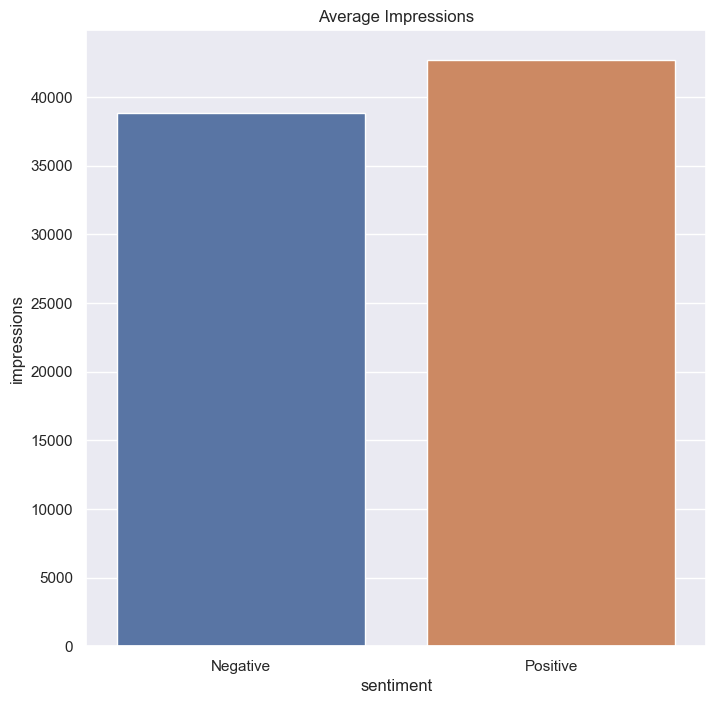

In [14]:
sns.set(rc={"figure.figsize":(8, 8)}) #width=12, #height=10
fig = sns.barplot(sentiment, x = 'sentiment',y='impressions',errorbar=None)
fig.set(title='Average Impressions')

Positive sentiment ads also seem to spend more on avergae. 

[Text(0.5, 1.0, 'Average Spend')]

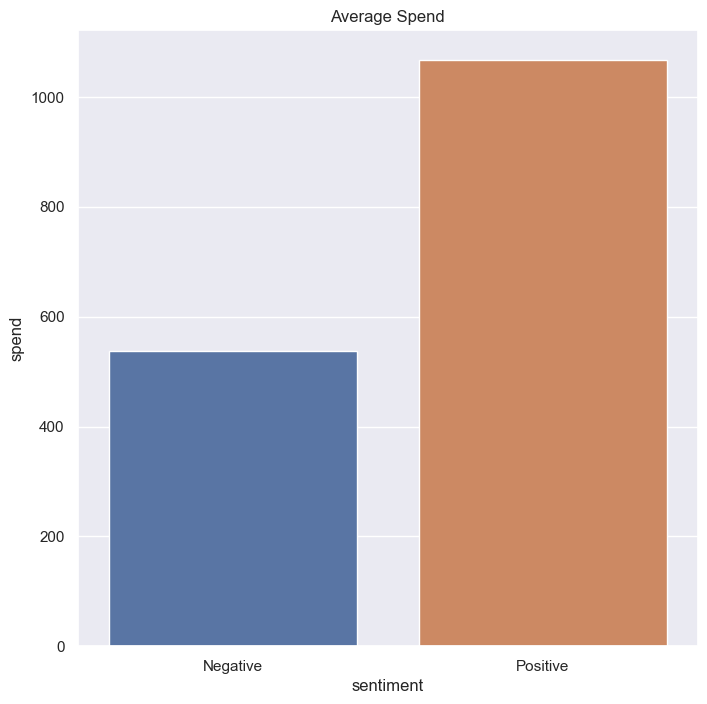

In [15]:
fig = sns.barplot(sentiment, x = 'sentiment',y='spend',errorbar=None)
fig.set(title='Average Spend')

Seems like Negative ads recieve a higher estimated audience.

[Text(0.5, 1.0, 'Average Estimated Audience Size')]

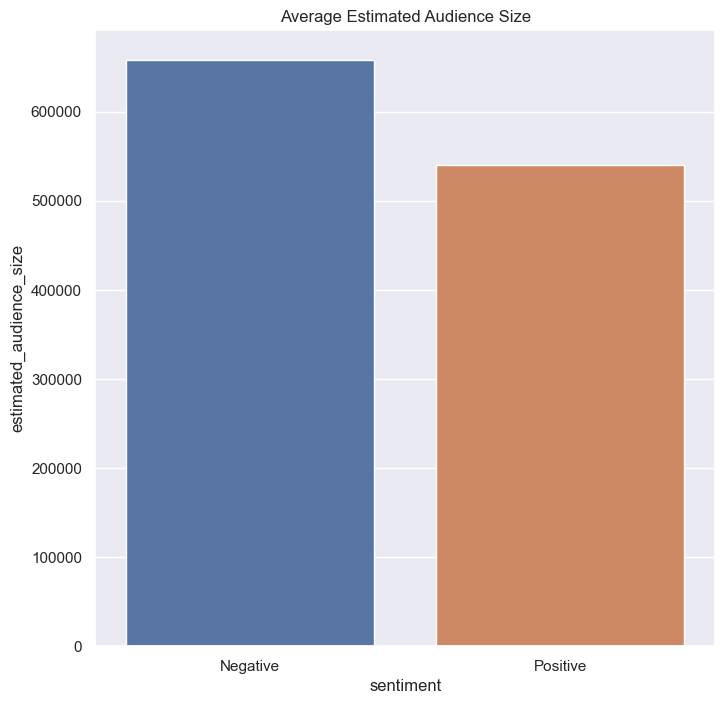

In [16]:
fig=sns.barplot(sentiment, x = 'sentiment',y='estimated_audience_size',errorbar=None)
fig.set(title='Average Estimated Audience Size')

## Examining Demographic Distributions

In [17]:
# based on 2020 election
right_wing = ['Alabama', 'Alaska', 'Arkansas', 'Florida', 'Idaho', 'Indiana', 
              'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Mississippi', 'Missouri', 
              'Montana', 'Nebraska', 'North Carolina', 'North Dakota', 'Ohio', 
              'Oklahoma', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 
              'Utah', 'West Virginia', 'Wyoming']
left_wing = ['Arizona', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Georgia', 
             'Hawaii', 'Illinois', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 
             'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'Oregon', 
             'Pennsylvania', 'Rhode Island', 'Vermont', 'Virginia', 'Washington', 'Wisconsin']

In [18]:
positive = df[df['sentiment'] == 'Positive']
negative = df[df['sentiment'] == 'Negative']

Takes in a series of demographic deistriubtions and gets the average demographic distribution.

In [19]:
def demographic_distributions(ser):
    '''
    Takes in the demographic_distribution column and convert it to df. 
    '''
    out_df = pd.DataFrame()

    for demo in ser:
        if str(demo) == 'nan':
            continue 

        flattened_data = []
        # Loop through each key-value pair in the dictionary
        for key, value in demo.items():
            # Loop through each dictionary in the list
            for d in value:
                # Add the key to the dictionary
                d["gender"] = key
                # Append the flattened dictionary to the list
                flattened_data.append(d)
        # Convert the flattened data to a pandas DataFrame
        temp_df = pd.DataFrame(flattened_data).groupby('gender').sum()

        if out_df.shape[0] == 0:
            out_df = temp_df
        else:
            out_df = pd.concat([out_df,temp_df])
    return out_df.groupby('gender').sum() / len(ser)

In [20]:
pos_demographics = demographic_distributions(positive['demographic_distribution']) * 100
neg_demographics =  demographic_distributions(negative['demographic_distribution']) * 100

In [21]:
# Rearraning columns
pos_demographics = pos_demographics[['13-17','18-24','25-34','35-44','45-54','55-64','65+']].loc[['female','male']]
neg_demographics = neg_demographics[['13-17','18-24','25-34','35-44','45-54','55-64','65+']].loc[['female','male']]

For positive sentiment ads there most common demogrpahics are female that are over the age of 65+ at 11%. There least common are males  in the age range of 13-17 at 0.34%.

In [22]:
pos_demographics

,13-17,18-24,25-34,35-44,45-54,55-64,65+
gender,,,,,,,
female,0.576567,5.983360,9.882555,9.384989,8.303580,9.125413,11.005298
male,0.348382,3.661947,7.514139,6.860045,6.176161,6.178742,6.078183


Breakdown among age groups for positive sentiment ads. Positive Sentiment have a more balanced demographic distribution with ages 25+ having around the same propritions of viewships.

[Text(0.5, 0, 'Age Groups'),
 Text(0, 0.5, 'Viewership (percentage %)'),
 Text(0.5, 1.0, 'Positive Sentiment Ads Age Distribution')]

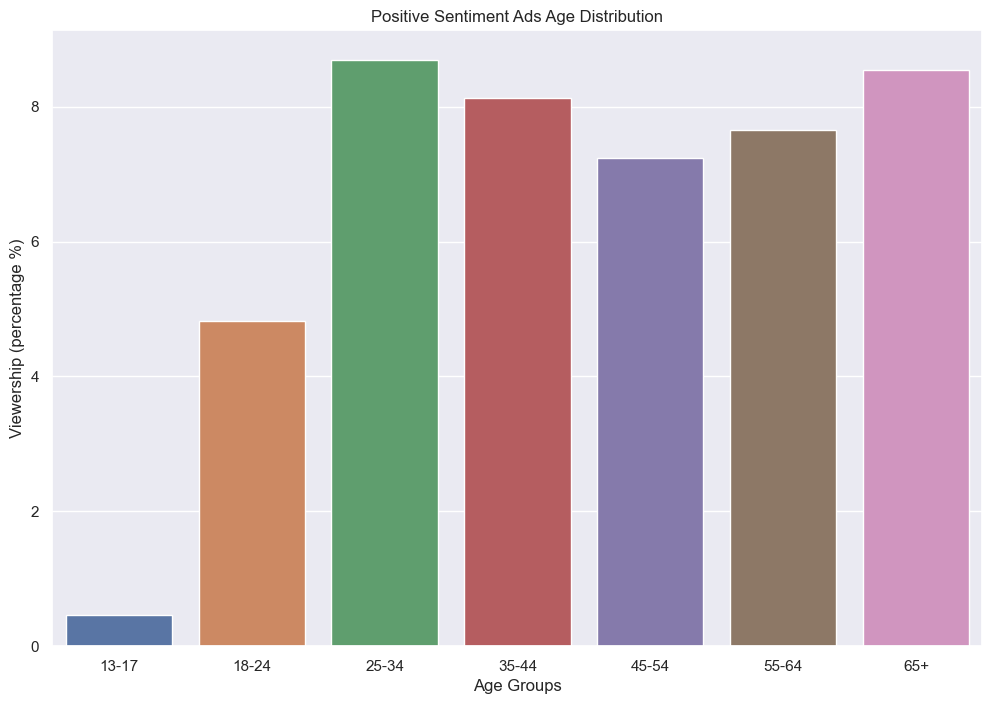

In [23]:
sns.set(rc={"figure.figsize":(12, 8)}) #width=12, #height=8
fig = sns.barplot(pos_demographics, errorbar=None)
fig.set(xlabel='Age Groups',
       ylabel='Viewership (percentage %)',
       title='Positive Sentiment Ads Age Distribution')

Most popular demographic among negative sentiment ads are females age 65+ 

In [24]:
neg_demographics

,13-17,18-24,25-34,35-44,45-54,55-64,65+
gender,,,,,,,
female,0.236605,2.756971,5.427331,6.587833,6.909282,10.123314,13.532440
male,0.098157,2.007028,5.715385,6.851973,7.665438,9.760914,9.727254


Demographic Distribution of Negative Sentiment Ads seem to attract a more older audience as there is a steady increase in percentage of viewships as the age group increases.

[Text(0.5, 0, 'Age Groups'),
 Text(0, 0.5, 'Viewership (percentage %)'),
 Text(0.5, 1.0, 'Negative Sentiment Ads Age Distribution')]

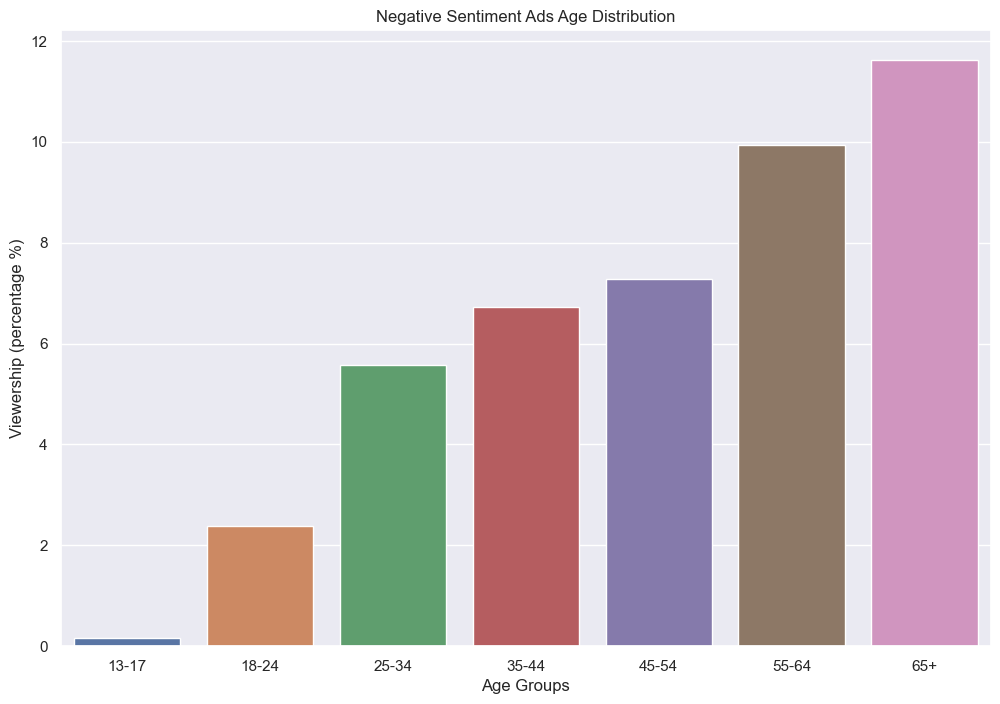

In [25]:
fig = sns.barplot(neg_demographics, errorbar=None)
fig.set(xlabel='Age Groups',
       ylabel='Viewership (percentage %)',
       title='Negative Sentiment Ads Age Distribution')

## Examining Delivery by Region

Variables to use in the function states_distribution.

In [26]:
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

states = ['Alabama', 'Alaska', 'Arkansas', 'Florida', 'Idaho', 'Indiana', 
              'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Mississippi', 'Missouri', 
              'Montana', 'Nebraska', 'North Carolina', 'North Dakota', 'Ohio', 
              'Oklahoma', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 
              'Utah', 'West Virginia', 'Wyoming','Arizona', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Georgia', 
             'Hawaii', 'Illinois', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 
             'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'Oregon', 
             'Pennsylvania', 'Rhode Island', 'Vermont', 'Virginia', 'Washington', 'Wisconsin']


There are **25 left-wing states** and **25 right-wing states**.

In [27]:
def states_distributions(ser):
    '''
    Takes in the delivery_by_region column and convert it to percentages. 
    '''
    states_df = {}
    for regions in ser:
        if str(regions) == 'nan':
            continue
        for region, percentage in regions.items():
            if region in states:
                if region not in states_df:
                    states_df[region] = percentage
                else:
                    states_df[region] += percentage
    states_df = pd.DataFrame(states_df,index=['percentage']).T
    states_df['percentage'] = states_df['percentage'] / len(ser)
    states_df['party'] = states_df.index.map(lambda x: 'left' if x in left_wing else 'right')
    states_df['state_code'] = states_df.index.map(lambda x: us_state_to_abbrev[x])
    return states_df

In [28]:
pos_reg = states_distributions(positive['delivery_by_region'])
neg_reg = states_distributions(negative['delivery_by_region'])

In [29]:
neg_reg.to_csv('negative_state_distribution.csv')

In [30]:
pos_reg.head()

,percentage,party,state_code
California,0.101699,left,CA
Alabama,0.012858,right,AL
Pennsylvania,0.035774,left,PA
Nevada,0.017306,left,NV
New Hampshire,0.004924,left,NH


### Creating Choropleths

In [31]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'iframe'

pd.options.plotting.backend = 'plotly'

pos_fig = px.choropleth(pos_reg,
                        locations='state_code', 
                        locationmode="USA-states", 
                        color='percentage',
                        color_continuous_scale="blues")
pos_fig.update_layout(
    title_text = 'Positive Sentiment Ads Across USA',
    geo_scope='usa', # limite map scope to USA
)

pos_fig.show()

In [32]:
neg_fig = px.choropleth(neg_reg,
                        locations='state_code', 
                        locationmode="USA-states", 
                        color='percentage',
                        color_continuous_scale="reds")
neg_fig.update_layout(
    title_text = 'Negative Sentiment Ads Across USA',
    geo_scope='usa', # limite map scope to USA
)

neg_fig.show()

Only noticable difference is that negative sentiment ads seem to be slightly more present in Texas but it's hard to tell across other states in the US as Texas and California have huge populations that dominate this feature.

### Differences in Proportions

There is a noticeable difference among the proportion of delivery. Left-wing states are delivered more positive sentiment ads about vaccines than right-wing states. Perhaps this not due to chance alone.

In [33]:
pos_reg.groupby('party')['percentage'].sum()

party
left     0.547399
right    0.360958
Name: percentage, dtype: float64

There is a difference among the proportion of delivery. Left-wing states recieve a higher proportion of negative sentiment ads than right-wing states. However, this difference is much smaller and could be due to chance alone. 

In [34]:
neg_reg.groupby('party')['percentage'].sum()

party
left     0.457064
right    0.415685
Name: percentage, dtype: float64

# Permutation Testing

**Do left-wing states recieve more positive ads related to COVID-19 vaccines vs right-wing states**? 

To answer this question we will be using permutation testing to determine if these two samples come from the same distribution.

### Setup

- **Null Hypothesis:** In the population, the proportion of left-wing states recieving positive sentiment ads is the same as the proportion of right-wing states, and the obsereved difference in our sample is due to random chance alone.
- **Alternative Hypothesis:** In the population the proportion of left-wing states recieving positive sentiment ads is greater than the proportion of right-wing states on average. The observed difference in our sample can not be explained due to chance alone. 
- **Test Statistics:** Difference in proportions.
$$\text{proportional sum of deliveries in left-wing states} - \text{proportional sum of deliveries right-wing states}$$

In [35]:
proportions = pos_reg.groupby('party')['percentage'].sum()
observed_difference = proportions.loc['left'] - proportions.loc['right']
observed_difference

0.18644042832469776

Simulating under the null hypothesis that the proportions are the same. 

In [36]:
n_repetitions = 100_000 # Performing 100,000 tests

differences = []
for _ in range(n_repetitions):
    
    # Step 1: Shuffle the deliviers and store them in a DataFrame.
    with_shuffled = neg_reg.assign(Shuffled_Parties=np.random.permutation(neg_reg['party']))

    # Step 2: Compute the test statistic.
    group_sums = with_shuffled.groupby('Shuffled_Parties')['percentage'].sum()
    difference = group_sums.loc['left'] - group_sums.loc['right']
    
    # Step 3: Store the result
    differences.append(difference)

In [37]:
fig = px.histogram(differences,nbins=50, title = 'Empirical Distribution of the Differences in Proportions of Percentage of Deliveries')
fig.add_vline(x=observed_difference, line_color='red')

In [38]:
p_value = np.array(differences >= observed_difference).mean()
p_value

0.05745

With a significance level of 0.05 we fail to reject the null hypothesis with a p-value of 0.057. Under the null hypothesis we see that it is not uncommon to see differences as large as 0.186. Therefore, we conclude that the two groups come from the same distribution. 